# Chapter 17: Sequence-to-Sequence Architectures: Encoder-Decoders and Decoders
Character-level encoder-decoder translator


Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Download the data

Have a look at the http://www.manythings.org/anki/ site and select a corpus with at least 10,000 pairs. You should understand the target language well. Ideally, it should be your mother tongue.
Then uncomment and run the lines below.

In [1]:
#!curl -O http://www.manythings.org/anki/fra-eng.zip
#!unzip fra-eng.zip
#!mkdir ../datasets/tatoeba
#!mv fra.txt ../datasets/tatoeba
#!rm fra-eng.zip _about.txt

In [2]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

## Modules

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

from torcheval.metrics.functional import bleu_score

import random
import numpy as np
import math

import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [5]:
num_samples = 100000  # Number of samples to train on.
max_len = 100  # max number of characters per sentence

In [6]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
DEVICE = torch.device(device)
DEVICE

device(type='mps')

## Dataset

### Creating the pairs

In [7]:
PATH = '../../pnlp/datasets/tatoeba/'

In [8]:
data_file = PATH + 'fra.txt'

In [9]:
with open(data_file, 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')

In [10]:
len(lines)

232736

In [11]:
# lines = lines[:num_samples]

In [12]:
def create_pairs(lines, max_len, num_samples, shuffle=True, anki=True):
    src_seqs = []
    tgt_seqs = []
    if shuffle:
        random.shuffle(lines)
    for line in lines:
        src_seq, tgt_seq, _ = line.split('\t')
        if len(src_seq) <= max_len and len(tgt_seq) <= max_len:
            src_seqs.append(src_seq)
            tgt_seqs.append(tgt_seq)
    return src_seqs[:num_samples], tgt_seqs[:num_samples]

In [13]:
tgt_seqs, src_seqs = create_pairs(lines, max_len, num_samples)

In [14]:
len(src_seqs)

100000

In [15]:
src_seqs[5]

"L'Italie n'est pas la Grèce."

In [16]:
tgt_seqs[5]

"Italy isn't Greece."

In [17]:
max(map(len, src_seqs)), max(map(len, tgt_seqs))

(100, 100)

### Train/Validation

Percentage train/validation

In [18]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val

80000

We split the lists

In [19]:
train_src_seqs = src_seqs[:train_val]
train_tgt_seqs = tgt_seqs[:train_val]

val_src_seqs = src_seqs[train_val:]
val_tgt_seqs = tgt_seqs[train_val:]

### The input and output symbols: Characters
The language pair shares the same vocabulary as in _Attention Is All You Need_

In [20]:
src_chars = set(''.join(train_src_seqs))
tgt_chars = set(''.join(train_tgt_seqs))
charset = sorted(
    list(set.union(src_chars,
                   tgt_chars)))
charset

[' ',
 '!',
 '"',
 '$',
 '%',
 "'",
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '°',
 '»',
 'À',
 'Â',
 'Ç',
 'É',
 'Ê',
 'Ô',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'ō',
 'œ',
 '\u2009',
 '\u200b',
 '–',
 '‘',
 '’',
 '\u202f',
 '€']

In [21]:
len(charset)

106

### Special symbols

In [22]:
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_tokens = ['<pad>', '<unk>', '<s>', '</s>']

In [23]:
charset = special_tokens + charset

In [24]:
idx2token = dict(enumerate(charset))
idx2token

{0: '<pad>',
 1: '<unk>',
 2: '<s>',
 3: '</s>',
 4: ' ',
 5: '!',
 6: '"',
 7: '$',
 8: '%',
 9: "'",
 10: ',',
 11: '-',
 12: '.',
 13: '/',
 14: '0',
 15: '1',
 16: '2',
 17: '3',
 18: '4',
 19: '5',
 20: '6',
 21: '7',
 22: '8',
 23: '9',
 24: ':',
 25: ';',
 26: '?',
 27: 'A',
 28: 'B',
 29: 'C',
 30: 'D',
 31: 'E',
 32: 'F',
 33: 'G',
 34: 'H',
 35: 'I',
 36: 'J',
 37: 'K',
 38: 'L',
 39: 'M',
 40: 'N',
 41: 'O',
 42: 'P',
 43: 'Q',
 44: 'R',
 45: 'S',
 46: 'T',
 47: 'U',
 48: 'V',
 49: 'W',
 50: 'X',
 51: 'Y',
 52: 'Z',
 53: 'a',
 54: 'b',
 55: 'c',
 56: 'd',
 57: 'e',
 58: 'f',
 59: 'g',
 60: 'h',
 61: 'i',
 62: 'j',
 63: 'k',
 64: 'l',
 65: 'm',
 66: 'n',
 67: 'o',
 68: 'p',
 69: 'q',
 70: 'r',
 71: 's',
 72: 't',
 73: 'u',
 74: 'v',
 75: 'w',
 76: 'x',
 77: 'y',
 78: 'z',
 79: '\xa0',
 80: '«',
 81: '°',
 82: '»',
 83: 'À',
 84: 'Â',
 85: 'Ç',
 86: 'É',
 87: 'Ê',
 88: 'Ô',
 89: 'à',
 90: 'â',
 91: 'ç',
 92: 'è',
 93: 'é',
 94: 'ê',
 95: 'ë',
 96: 'î',
 97: 'ï',
 98: 'ô',
 99:

In [25]:
token2idx = {char: idx for idx, char
             in idx2token.items()}
token2idx

{'<pad>': 0,
 '<unk>': 1,
 '<s>': 2,
 '</s>': 3,
 ' ': 4,
 '!': 5,
 '"': 6,
 '$': 7,
 '%': 8,
 "'": 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '?': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 'a': 53,
 'b': 54,
 'c': 55,
 'd': 56,
 'e': 57,
 'f': 58,
 'g': 59,
 'h': 60,
 'i': 61,
 'j': 62,
 'k': 63,
 'l': 64,
 'm': 65,
 'n': 66,
 'o': 67,
 'p': 68,
 'q': 69,
 'r': 70,
 's': 71,
 't': 72,
 'u': 73,
 'v': 74,
 'w': 75,
 'x': 76,
 'y': 77,
 'z': 78,
 '\xa0': 79,
 '«': 80,
 '°': 81,
 '»': 82,
 'À': 83,
 'Â': 84,
 'Ç': 85,
 'É': 86,
 'Ê': 87,
 'Ô': 88,
 'à': 89,
 'â': 90,
 'ç': 91,
 'è': 92,
 'é': 93,
 'ê': 94,
 'ë': 95,
 'î': 96,
 'ï': 97,
 'ô': 98,
 'ù'

In [26]:
len(idx2token)

110

### Text Encoding

In [27]:
def seqs2tensors(seqs, token2idx):
    tensors = []
    for seq in seqs:
        seq = ['<s>'] + list(seq) + ['</s>']
        tensors += torch.tensor([
            list(map(lambda x: token2idx.get(x, 1),
                     seq))])  # <unk> -> 1
    return tensors

In [28]:
train_src_seqs[:2]

['Vous pouvez vous en aller.', 'Quel remède recommandez-vous\u202f?']

In [29]:
train_tgt_seqs[:2]

['You may go.', 'What medicine do you recommend?']

In [30]:
seqs2tensors(train_tgt_seqs[:2], token2idx)

[tensor([ 2, 51, 67, 73,  4, 65, 53, 77,  4, 59, 67, 12,  3]),
 tensor([ 2, 49, 60, 53, 72,  4, 65, 57, 56, 61, 55, 61, 66, 57,  4, 56, 67,  4,
         77, 67, 73,  4, 70, 57, 55, 67, 65, 65, 57, 66, 56, 26,  3])]

In [31]:
seqs2tensors(train_tgt_seqs, token2idx)[:3]

[tensor([ 2, 51, 67, 73,  4, 65, 53, 77,  4, 59, 67, 12,  3]),
 tensor([ 2, 49, 60, 53, 72,  4, 65, 57, 56, 61, 55, 61, 66, 57,  4, 56, 67,  4,
         77, 67, 73,  4, 70, 57, 55, 67, 65, 65, 57, 66, 56, 26,  3]),
 tensor([ 2, 29, 67, 65, 57,  4, 54, 53, 55, 63,  4, 64, 53, 72, 57, 70, 12,  3])]

In [32]:
def tensors2seqs(tensors, idx2token):
    seqs = []
    for tensor in tensors:
        tensor = list(tensor)
        seqs += [list(
            map(lambda x: idx2token.get(x.item(), '<unk>'),
                tensor))]
    return seqs

In [33]:
tensors2seqs(seqs2tensors(train_src_seqs, token2idx)[:3], idx2token)

[['<s>',
  'V',
  'o',
  'u',
  's',
  ' ',
  'p',
  'o',
  'u',
  'v',
  'e',
  'z',
  ' ',
  'v',
  'o',
  'u',
  's',
  ' ',
  'e',
  'n',
  ' ',
  'a',
  'l',
  'l',
  'e',
  'r',
  '.',
  '</s>'],
 ['<s>',
  'Q',
  'u',
  'e',
  'l',
  ' ',
  'r',
  'e',
  'm',
  'è',
  'd',
  'e',
  ' ',
  'r',
  'e',
  'c',
  'o',
  'm',
  'm',
  'a',
  'n',
  'd',
  'e',
  'z',
  '-',
  'v',
  'o',
  'u',
  's',
  '\u202f',
  '?',
  '</s>'],
 ['<s>',
  'R',
  'e',
  'v',
  'i',
  'e',
  'n',
  's',
  ' ',
  'p',
  'l',
  'u',
  's',
  ' ',
  't',
  'a',
  'r',
  'd',
  '.',
  '</s>']]

## Model

In [34]:
class Embedding(nn.Module):
    def __init__(self,
                 vocab_size,
                 d_model,
                 dropout=0.1,
                 max_len=max_len):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.input_embedding = nn.Embedding(vocab_size, d_model,
                                            padding_idx=0)
        pe = self.pos_encoding(max_len, d_model)
        self.pos_embedding = nn.Embedding.from_pretrained(
            pe, freeze=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        pos_mat = torch.arange(X.size(dim=-1), device=X.device)
        X = self.input_embedding(X) * math.sqrt(self.d_model)
        X += self.pos_embedding(pos_mat)
        return self.dropout(X)

    def pos_encoding(self, max_len, d_model):
        dividend = torch.arange(max_len).unsqueeze(0).T
        divisor = torch.pow(10000.0,
                            torch.arange(0, d_model, 2)/d_model)
        angles = dividend / divisor
        pe = torch.zeros((max_len, d_model))
        pe[:, 0::2] = torch.sin(angles)
        pe[:, 1::2] = torch.cos(angles)
        return pe

In [35]:
embeddings = Embedding(5, 10, dropout=0.0)

In [36]:
embeddings

Embedding(
  (input_embedding): Embedding(5, 10, padding_idx=0)
  (pos_embedding): Embedding(100, 10)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [37]:
class Translator(nn.Module):
    def __init__(self,
                 d_model=512,
                 nhead=8,
                 num_encoder_layers=6,
                 num_decoder_layers=6,
                 dim_feedforward=2048,  # 4 x d_model
                 dropout=0.1,
                 vocab_size=30000,
                 max_len=128):
        super().__init__()
        self.embedding = Embedding(vocab_size,
                                   d_model,
                                   max_len=max_len)
        self.transformer = nn.Transformer(
            d_model,
            nhead,
            num_encoder_layers,
            num_decoder_layers,
            dim_feedforward,
            dropout,
            batch_first=True)
        self.fc = nn.Linear(d_model, vocab_size)
        self.fc.weight = \
            self.embedding.input_embedding.weight

    def forward(self, src, tgt,
                src_padding, tgt_padding):
        src_embs = self.embedding(src)
        tgt_embs = self.embedding(tgt)
        tgt_mask = \
            nn.Transformer.generate_square_subsequent_mask(
                tgt.size(dim=1), device=DEVICE)
        x = self.transformer(
            src_embs,
            tgt_embs,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding,
            memory_key_padding_mask=src_padding,
            tgt_key_padding_mask=tgt_padding)
        return self.fc(x)

In [38]:
translator = Translator(vocab_size=len(idx2token)).to(DEVICE)

In [39]:
src_batch = pad_sequence(seqs2tensors(
    train_src_seqs[:32], token2idx),
    batch_first=True, padding_value=0).to(DEVICE)
tgt_batch = pad_sequence(seqs2tensors(
    train_tgt_seqs[:32], token2idx),
    batch_first=True, padding_value=0).to(DEVICE)

In [40]:
translator.eval()
translator(src_batch, tgt_batch, None, None).size()

torch.Size([32, 70, 110])

In [41]:
src_padding_mask = (src_batch == 0)
tgt_padding_mask = (tgt_batch == 0).float()

In [42]:
src_padding_mask = src_padding_mask.to(DEVICE)
src_padding_mask

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]], device='mps:0')

In [43]:
tgt_padding_mask = tgt_padding_mask.to(DEVICE)
tgt_padding_mask

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]], device='mps:0')

In [44]:
translator(src_batch, tgt_batch,
           src_padding_mask, tgt_padding_mask).size()

/opt/anaconda3/lib/python3.13/site-packages/torch/nn/modules/transformer.py:467: UserWarning: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  ) and not torch._nested_tensor_from_mask_left_aligned(


torch.Size([32, 70, 110])

In [45]:
tensors2seqs(
    torch.argmax(
        translator(src_batch, tgt_batch,
                   src_padding_mask, tgt_padding_mask),
        dim=-1),
    idx2token)

[['î',
  'î',
  '»',
  '»',
  'î',
  '»',
  '»',
  '»',
  'î',
  'î',
  '»',
  'î',
  'î',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  '»',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  '»',
  '»',
  'î',
  'î',
  'î',
  'î',
  'î'],
 ['î',
  'ï',
  'î',
  'N',
  'î',
  ' ',
  '»',
  '8',
  '»',
  '8',
  '8',
  '8',
  '8',
  '8',
  ' ',
  'î',
  '8',
  ' ',
  '8',
  '/',
  '»',
  ' ',
  'î',
  '8',
  '8',
  '/',
  '»',
  '»',
  '8',
  '8',
  '»',
  '?',
  '8',
  '/',
  '/',
  '/',
  '/',
  '/',
  '/',
  '/',
  '/',
  '/',
  '/',
  '/',
  '/',
  '8',
  '8',
  '/',
  '/',
  '/',
  '/',
  '8',
  '8',
  '8',
  '8',
  '/',
  '/',
  '8',
  '8',
  '8',
  '8',
  '8',
  '/',
  '8',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î'],
 ['î',
  'î',
  'î

## Model Creation

In [46]:
token2idx

{'<pad>': 0,
 '<unk>': 1,
 '<s>': 2,
 '</s>': 3,
 ' ': 4,
 '!': 5,
 '"': 6,
 '$': 7,
 '%': 8,
 "'": 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '?': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 'a': 53,
 'b': 54,
 'c': 55,
 'd': 56,
 'e': 57,
 'f': 58,
 'g': 59,
 'h': 60,
 'i': 61,
 'j': 62,
 'k': 63,
 'l': 64,
 'm': 65,
 'n': 66,
 'o': 67,
 'p': 68,
 'q': 69,
 'r': 70,
 's': 71,
 't': 72,
 'u': 73,
 'v': 74,
 'w': 75,
 'x': 76,
 'y': 77,
 'z': 78,
 '\xa0': 79,
 '«': 80,
 '°': 81,
 '»': 82,
 'À': 83,
 'Â': 84,
 'Ç': 85,
 'É': 86,
 'Ê': 87,
 'Ô': 88,
 'à': 89,
 'â': 90,
 'ç': 91,
 'è': 92,
 'é': 93,
 'ê': 94,
 'ë': 95,
 'î': 96,
 'ï': 97,
 'ô': 98,
 'ù'

In [47]:
VOCAB_SIZE = len(token2idx)
D_MODEL = 512
NHEAD = 8
DIM_FF = 512
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
MAX_LEN = max_len + 2  # start and end
WARMUP_STEPS = 4000
MODEL_NAME = 'pico_model.pth'

In [48]:
token2idx

{'<pad>': 0,
 '<unk>': 1,
 '<s>': 2,
 '</s>': 3,
 ' ': 4,
 '!': 5,
 '"': 6,
 '$': 7,
 '%': 8,
 "'": 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '?': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 'a': 53,
 'b': 54,
 'c': 55,
 'd': 56,
 'e': 57,
 'f': 58,
 'g': 59,
 'h': 60,
 'i': 61,
 'j': 62,
 'k': 63,
 'l': 64,
 'm': 65,
 'n': 66,
 'o': 67,
 'p': 68,
 'q': 69,
 'r': 70,
 's': 71,
 't': 72,
 'u': 73,
 'v': 74,
 'w': 75,
 'x': 76,
 'y': 77,
 'z': 78,
 '\xa0': 79,
 '«': 80,
 '°': 81,
 '»': 82,
 'À': 83,
 'Â': 84,
 'Ç': 85,
 'É': 86,
 'Ê': 87,
 'Ô': 88,
 'à': 89,
 'â': 90,
 'ç': 91,
 'è': 92,
 'é': 93,
 'ê': 94,
 'ë': 95,
 'î': 96,
 'ï': 97,
 'ô': 98,
 'ù'

In [49]:
translator = Translator(d_model=D_MODEL,
                        nhead=NHEAD,
                        num_decoder_layers=NUM_ENCODER_LAYERS,
                        num_encoder_layers=NUM_DECODER_LAYERS,
                        dim_feedforward=DIM_FF,
                        vocab_size=VOCAB_SIZE,
                        max_len=MAX_LEN)

In [50]:
translator

Translator(
  (embedding): Embedding(
    (input_embedding): Embedding(110, 512, padding_idx=0)
    (pos_embedding): Embedding(102, 512)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwis

In [51]:
for p in translator.parameters():
    if p.requires_grad and p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [52]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=0)

We set the learning rate to 1 as we will use a scheduler. Otherwise `lr=0.0001`

In [53]:
optimizer = torch.optim.Adam(
    translator.parameters(), lr=1, betas=(0.9, 0.98),
    eps=1e-9)
"""optimizer = torch.optim.NAdam(translator.parameters())"""

'optimizer = torch.optim.NAdam(translator.parameters())'

## Warmup Steps

We use the definition from Vaswani and a possible scaling factor

In [54]:
def learning_rate(step_num, d_model, factor, warmup_steps):
    if step_num == 0:
        step_num = 1
    return factor * (
        d_model ** (-0.5) * min(step_num * warmup_steps **
                                (-1.5), step_num ** (-0.5))
    )

In [55]:
lr_scheduler = LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda step_num: learning_rate(
        step_num, d_model=D_MODEL, factor=1.0, warmup_steps=WARMUP_STEPS
    ),
)

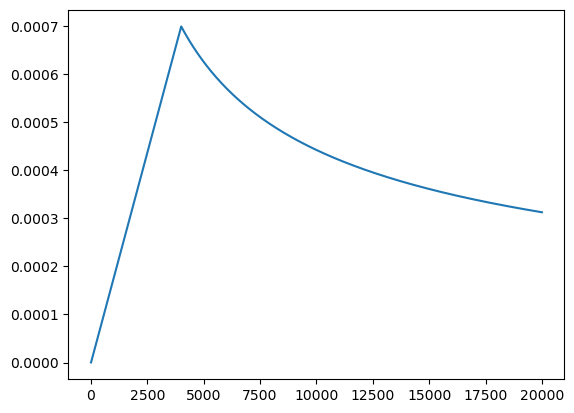

In [56]:
plt.plot([learning_rate(i, D_MODEL, 1.0, WARMUP_STEPS)
         for i in range(0, 20000)])

## Formatting the Data
We use `Dataset` and `DataLoader`. `Dataset` implements two methods: `__init__`, `__len__` and `__getitem__`. The last method returns an item of the dataset given an index. Using `collate_fn`, `DataLoader` returns a batch of `batch_size` samples.

In [57]:
from torch.utils.data import Dataset, DataLoader

In [58]:
class PairDataset(Dataset):
    def __init__(self, src_seqs, tgt_seqs,
                 token2idx):
        self.src_seqs = src_seqs
        self.tgt_seqs = tgt_seqs
        self.token2idx = token2idx

    def __len__(self):
        return len(self.src_seqs)

    def __getitem__(self, idx):
        src_batch = seqs2tensors([self.src_seqs[idx]],
                                 self.token2idx)
        tgt_batch = seqs2tensors([self.tgt_seqs[idx]],
                                 self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, batch_first=True,
                                 padding_value=0)
        tgt_batch = pad_sequence(tgt_batch, batch_first=True,
                                 padding_value=0)

        return src_batch, tgt_batch

In [59]:
train_dataset = PairDataset(train_src_seqs, train_tgt_seqs,
                            token2idx)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True,
                              collate_fn=train_dataset.collate)

In [60]:
val_dataset = PairDataset(val_src_seqs, val_tgt_seqs, token2idx)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)

## Training Loop

In [61]:
src_batch

tensor([[ 2, 48, 67,  ...,  0,  0,  0],
        [ 2, 43, 73,  ...,  0,  0,  0],
        [ 2, 44, 57,  ...,  0,  0,  0],
        ...,
        [ 2, 36, 57,  ...,  0,  0,  0],
        [ 2, 38, 57,  ...,  0,  0,  0],
        [ 2, 48, 57,  ...,  0,  0,  0]], device='mps:0')

In [62]:
src_batch[:, 1:]

tensor([[48, 67, 73,  ...,  0,  0,  0],
        [43, 73, 57,  ...,  0,  0,  0],
        [44, 57, 74,  ...,  0,  0,  0],
        ...,
        [36, 57,  4,  ...,  0,  0,  0],
        [38, 57,  4,  ...,  0,  0,  0],
        [48, 57, 66,  ...,  0,  0,  0]], device='mps:0')

In [63]:
translator = translator.to(DEVICE)

In [64]:
def evaluate(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        t_loss = 0
        t_correct, t_chars = 0, 0
        for src_batch, tgt_batch in dataloader:
            src_batch = src_batch.to(DEVICE)
            tgt_batch = tgt_batch.to(DEVICE)
            tgt_input = tgt_batch[:, :-1]
            tgt_output = tgt_batch[:, 1:]
            src_padding_mask = (src_batch == 0)
            tgt_padding_mask = (tgt_input == 0).float()
            tgt_output_pred = model(src_batch, tgt_input,
                                    src_padding_mask,
                                    tgt_padding_mask)
            loss = loss_fn(
                tgt_output_pred.reshape(
                    -1,
                    tgt_output_pred.size(dim=-1)),
                tgt_output.reshape(-1))
            n_chars = (tgt_output != 0).sum()
            t_chars += n_chars
            t_loss += loss.item() * n_chars
            char_pred = torch.argmax(tgt_output_pred, dim=-1)
            char_correct = torch.mul((char_pred == tgt_output),
                                     (tgt_output != 0)).sum()
            t_correct += char_correct.item()
        return t_loss / t_chars, t_correct / t_chars

In [65]:
evaluate(translator, loss_fn, val_dataloader)

(tensor(6.7526, device='mps:0'), tensor(0.0174, device='mps:0'))

In [66]:
def train(model, loss_fn, optimizer, dataloader):
    model.train()
    t_loss = 0
    t_correct, t_chars = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        src_batch = src_batch.to(DEVICE)
        tgt_batch = tgt_batch.to(DEVICE)
        tgt_input = tgt_batch[:, :-1]
        tgt_output = tgt_batch[:, 1:]
        src_padding_mask = (src_batch == 0).to(DEVICE)
        tgt_padding_mask = (tgt_input == 0).float().to(DEVICE)
        tgt_output_pred = model(src_batch, tgt_input,
                                src_padding_mask,
                                tgt_padding_mask)
        optimizer.zero_grad()
        loss = loss_fn(
            tgt_output_pred.reshape(
                -1,
                tgt_output_pred.size(dim=-1)),
            tgt_output.reshape(-1))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        with torch.no_grad():
            n_chars = (tgt_output != 0).sum()
            t_chars += n_chars
            t_loss += loss.item() * n_chars
            char_pred = torch.argmax(tgt_output_pred, dim=-1)
            char_correct = torch.mul((char_pred == tgt_output),
                                     (tgt_output != 0)).sum()
            t_correct += char_correct.item()

    return t_loss / t_chars, t_correct / t_chars

In [67]:
#translator = torch.compile(translator)

About the loss. Overall, it should computed by individual prediction and divided by the number of chars. By default the crossentropy loss uses the mean. Then we use the mean of the mean. The trend is correct, but the values are not exact. A possible improvement would be to sum and pass through the mask.

In [68]:
EPOCHS = 80
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(
        translator, loss_fn, optimizer, train_dataloader)
    history['loss'] += [train_loss.item()]
    history['accuracy'] += [train_acc.item()]
    val_loss, val_acc = evaluate(translator, loss_fn, val_dataloader)
    history['val_loss'] += [val_loss.item()]
    history['val_accuracy'] += [val_acc.item()]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}"))

100%|██████████| 2500/2500 [05:12<00:00,  8.00it/s]


Epoch: 0, Train loss: 2.403, Val loss: 1.869, Train acc.: 0.462, Val acc.: 0.624


100%|██████████| 2500/2500 [04:54<00:00,  8.50it/s]


Epoch: 1, Train loss: 1.844, Val loss: 1.671, Train acc.: 0.631, Val acc.: 0.692


100%|██████████| 2500/2500 [04:51<00:00,  8.56it/s]


Epoch: 2, Train loss: 1.659, Val loss: 1.523, Train acc.: 0.696, Val acc.: 0.745


100%|██████████| 2500/2500 [04:53<00:00,  8.52it/s]


Epoch: 3, Train loss: 1.529, Val loss: 1.407, Train acc.: 0.743, Val acc.: 0.790


100%|██████████| 2500/2500 [04:52<00:00,  8.54it/s]


Epoch: 4, Train loss: 1.432, Val loss: 1.329, Train acc.: 0.780, Val acc.: 0.819


100%|██████████| 2500/2500 [04:55<00:00,  8.47it/s]


Epoch: 5, Train loss: 1.361, Val loss: 1.273, Train acc.: 0.805, Val acc.: 0.840


100%|██████████| 2500/2500 [04:54<00:00,  8.48it/s]


Epoch: 6, Train loss: 1.309, Val loss: 1.230, Train acc.: 0.824, Val acc.: 0.855


100%|██████████| 2500/2500 [04:54<00:00,  8.50it/s]


Epoch: 7, Train loss: 1.269, Val loss: 1.204, Train acc.: 0.838, Val acc.: 0.864


100%|██████████| 2500/2500 [04:53<00:00,  8.51it/s]


Epoch: 8, Train loss: 1.237, Val loss: 1.184, Train acc.: 0.849, Val acc.: 0.871


100%|██████████| 2500/2500 [04:55<00:00,  8.46it/s]


Epoch: 9, Train loss: 1.212, Val loss: 1.162, Train acc.: 0.858, Val acc.: 0.879


100%|██████████| 2500/2500 [04:56<00:00,  8.44it/s]


Epoch: 10, Train loss: 1.190, Val loss: 1.148, Train acc.: 0.865, Val acc.: 0.884


100%|██████████| 2500/2500 [04:56<00:00,  8.42it/s]


Epoch: 11, Train loss: 1.172, Val loss: 1.138, Train acc.: 0.871, Val acc.: 0.888


100%|██████████| 2500/2500 [04:49<00:00,  8.64it/s]


Epoch: 12, Train loss: 1.157, Val loss: 1.126, Train acc.: 0.877, Val acc.: 0.892


100%|██████████| 2500/2500 [04:51<00:00,  8.57it/s]


Epoch: 13, Train loss: 1.143, Val loss: 1.120, Train acc.: 0.881, Val acc.: 0.894


100%|██████████| 2500/2500 [04:53<00:00,  8.51it/s]


Epoch: 14, Train loss: 1.130, Val loss: 1.108, Train acc.: 0.885, Val acc.: 0.898


100%|██████████| 2500/2500 [04:55<00:00,  8.45it/s]


Epoch: 15, Train loss: 1.119, Val loss: 1.104, Train acc.: 0.889, Val acc.: 0.900


100%|██████████| 2500/2500 [04:52<00:00,  8.55it/s]


Epoch: 16, Train loss: 1.109, Val loss: 1.099, Train acc.: 0.892, Val acc.: 0.902


100%|██████████| 2500/2500 [04:52<00:00,  8.56it/s]


Epoch: 17, Train loss: 1.100, Val loss: 1.093, Train acc.: 0.896, Val acc.: 0.903


100%|██████████| 2500/2500 [04:50<00:00,  8.61it/s]


Epoch: 18, Train loss: 1.092, Val loss: 1.088, Train acc.: 0.898, Val acc.: 0.905


100%|██████████| 2500/2500 [04:52<00:00,  8.56it/s]


Epoch: 19, Train loss: 1.084, Val loss: 1.086, Train acc.: 0.901, Val acc.: 0.906


100%|██████████| 2500/2500 [04:53<00:00,  8.51it/s]


Epoch: 20, Train loss: 1.077, Val loss: 1.081, Train acc.: 0.903, Val acc.: 0.908


100%|██████████| 2500/2500 [04:53<00:00,  8.51it/s]


Epoch: 21, Train loss: 1.071, Val loss: 1.077, Train acc.: 0.905, Val acc.: 0.909


100%|██████████| 2500/2500 [04:53<00:00,  8.52it/s]


Epoch: 22, Train loss: 1.065, Val loss: 1.074, Train acc.: 0.907, Val acc.: 0.910


100%|██████████| 2500/2500 [04:53<00:00,  8.51it/s]


Epoch: 23, Train loss: 1.058, Val loss: 1.072, Train acc.: 0.909, Val acc.: 0.912


100%|██████████| 2500/2500 [04:50<00:00,  8.60it/s]


Epoch: 24, Train loss: 1.053, Val loss: 1.068, Train acc.: 0.911, Val acc.: 0.913


100%|██████████| 2500/2500 [04:51<00:00,  8.57it/s]


Epoch: 25, Train loss: 1.048, Val loss: 1.068, Train acc.: 0.913, Val acc.: 0.913


100%|██████████| 2500/2500 [04:54<00:00,  8.49it/s]


Epoch: 26, Train loss: 1.043, Val loss: 1.062, Train acc.: 0.914, Val acc.: 0.914


100%|██████████| 2500/2500 [04:51<00:00,  8.58it/s]


Epoch: 27, Train loss: 1.038, Val loss: 1.061, Train acc.: 0.916, Val acc.: 0.915


100%|██████████| 2500/2500 [04:52<00:00,  8.54it/s]


Epoch: 28, Train loss: 1.034, Val loss: 1.062, Train acc.: 0.917, Val acc.: 0.915


100%|██████████| 2500/2500 [04:51<00:00,  8.57it/s]


Epoch: 29, Train loss: 1.029, Val loss: 1.061, Train acc.: 0.919, Val acc.: 0.915


100%|██████████| 2500/2500 [04:48<00:00,  8.67it/s]


Epoch: 30, Train loss: 1.026, Val loss: 1.057, Train acc.: 0.920, Val acc.: 0.917


100%|██████████| 2500/2500 [04:49<00:00,  8.63it/s]


Epoch: 31, Train loss: 1.022, Val loss: 1.056, Train acc.: 0.921, Val acc.: 0.917


100%|██████████| 2500/2500 [04:51<00:00,  8.57it/s]


Epoch: 32, Train loss: 1.018, Val loss: 1.055, Train acc.: 0.922, Val acc.: 0.918


100%|██████████| 2500/2500 [04:47<00:00,  8.70it/s]


Epoch: 33, Train loss: 1.015, Val loss: 1.053, Train acc.: 0.923, Val acc.: 0.918


100%|██████████| 2500/2500 [04:49<00:00,  8.63it/s]


Epoch: 34, Train loss: 1.012, Val loss: 1.052, Train acc.: 0.925, Val acc.: 0.919


100%|██████████| 2500/2500 [04:49<00:00,  8.63it/s]


Epoch: 35, Train loss: 1.008, Val loss: 1.052, Train acc.: 0.925, Val acc.: 0.919


100%|██████████| 2500/2500 [04:49<00:00,  8.65it/s]


Epoch: 36, Train loss: 1.005, Val loss: 1.050, Train acc.: 0.927, Val acc.: 0.920


100%|██████████| 2500/2500 [04:50<00:00,  8.61it/s]


Epoch: 37, Train loss: 1.002, Val loss: 1.048, Train acc.: 0.927, Val acc.: 0.920


100%|██████████| 2500/2500 [04:51<00:00,  8.59it/s]


Epoch: 38, Train loss: 1.000, Val loss: 1.049, Train acc.: 0.928, Val acc.: 0.921


100%|██████████| 2500/2500 [04:52<00:00,  8.55it/s]


Epoch: 39, Train loss: 0.996, Val loss: 1.048, Train acc.: 0.929, Val acc.: 0.921


100%|██████████| 2500/2500 [04:52<00:00,  8.56it/s]


Epoch: 40, Train loss: 0.994, Val loss: 1.046, Train acc.: 0.930, Val acc.: 0.922


100%|██████████| 2500/2500 [04:50<00:00,  8.60it/s]


Epoch: 41, Train loss: 0.991, Val loss: 1.046, Train acc.: 0.931, Val acc.: 0.922


100%|██████████| 2500/2500 [04:49<00:00,  8.63it/s]


Epoch: 42, Train loss: 0.989, Val loss: 1.046, Train acc.: 0.932, Val acc.: 0.922


100%|██████████| 2500/2500 [04:50<00:00,  8.62it/s]


Epoch: 43, Train loss: 0.987, Val loss: 1.045, Train acc.: 0.933, Val acc.: 0.922


100%|██████████| 2500/2500 [04:51<00:00,  8.57it/s]


Epoch: 44, Train loss: 0.984, Val loss: 1.045, Train acc.: 0.933, Val acc.: 0.923


100%|██████████| 2500/2500 [04:49<00:00,  8.64it/s]


Epoch: 45, Train loss: 0.982, Val loss: 1.044, Train acc.: 0.934, Val acc.: 0.923


100%|██████████| 2500/2500 [04:52<00:00,  8.54it/s]


Epoch: 46, Train loss: 0.979, Val loss: 1.045, Train acc.: 0.935, Val acc.: 0.923


100%|██████████| 2500/2500 [04:49<00:00,  8.62it/s]


Epoch: 47, Train loss: 0.977, Val loss: 1.044, Train acc.: 0.936, Val acc.: 0.923


100%|██████████| 2500/2500 [04:50<00:00,  8.61it/s]


Epoch: 48, Train loss: 0.975, Val loss: 1.043, Train acc.: 0.937, Val acc.: 0.923


100%|██████████| 2500/2500 [04:51<00:00,  8.57it/s]


Epoch: 49, Train loss: 0.973, Val loss: 1.044, Train acc.: 0.937, Val acc.: 0.923


100%|██████████| 2500/2500 [04:49<00:00,  8.64it/s]


Epoch: 50, Train loss: 0.971, Val loss: 1.043, Train acc.: 0.938, Val acc.: 0.924


100%|██████████| 2500/2500 [04:51<00:00,  8.59it/s]


Epoch: 51, Train loss: 0.970, Val loss: 1.041, Train acc.: 0.938, Val acc.: 0.925


100%|██████████| 2500/2500 [04:50<00:00,  8.62it/s]


Epoch: 52, Train loss: 0.967, Val loss: 1.042, Train acc.: 0.939, Val acc.: 0.925


100%|██████████| 2500/2500 [04:48<00:00,  8.66it/s]


Epoch: 53, Train loss: 0.966, Val loss: 1.042, Train acc.: 0.939, Val acc.: 0.925


100%|██████████| 2500/2500 [04:50<00:00,  8.60it/s]


Epoch: 54, Train loss: 0.964, Val loss: 1.041, Train acc.: 0.940, Val acc.: 0.925


100%|██████████| 2500/2500 [04:51<00:00,  8.58it/s]


Epoch: 55, Train loss: 0.962, Val loss: 1.041, Train acc.: 0.940, Val acc.: 0.925


100%|██████████| 2500/2500 [04:51<00:00,  8.59it/s]


Epoch: 56, Train loss: 0.960, Val loss: 1.040, Train acc.: 0.941, Val acc.: 0.925


100%|██████████| 2500/2500 [04:50<00:00,  8.60it/s]


Epoch: 57, Train loss: 0.959, Val loss: 1.041, Train acc.: 0.942, Val acc.: 0.925


100%|██████████| 2500/2500 [04:50<00:00,  8.60it/s]


Epoch: 58, Train loss: 0.957, Val loss: 1.041, Train acc.: 0.942, Val acc.: 0.926


100%|██████████| 2500/2500 [04:47<00:00,  8.71it/s]


Epoch: 59, Train loss: 0.955, Val loss: 1.040, Train acc.: 0.943, Val acc.: 0.926


100%|██████████| 2500/2500 [04:50<00:00,  8.60it/s]


Epoch: 60, Train loss: 0.954, Val loss: 1.040, Train acc.: 0.943, Val acc.: 0.926


100%|██████████| 2500/2500 [04:49<00:00,  8.63it/s]


Epoch: 61, Train loss: 0.952, Val loss: 1.040, Train acc.: 0.944, Val acc.: 0.926


100%|██████████| 2500/2500 [04:51<00:00,  8.58it/s]


Epoch: 62, Train loss: 0.951, Val loss: 1.041, Train acc.: 0.944, Val acc.: 0.926


100%|██████████| 2500/2500 [04:50<00:00,  8.60it/s]


Epoch: 63, Train loss: 0.949, Val loss: 1.040, Train acc.: 0.945, Val acc.: 0.926


100%|██████████| 2500/2500 [04:50<00:00,  8.62it/s]


Epoch: 64, Train loss: 0.948, Val loss: 1.040, Train acc.: 0.945, Val acc.: 0.927


100%|██████████| 2500/2500 [04:48<00:00,  8.67it/s]


Epoch: 65, Train loss: 0.946, Val loss: 1.040, Train acc.: 0.946, Val acc.: 0.926


100%|██████████| 2500/2500 [04:49<00:00,  8.63it/s]


Epoch: 66, Train loss: 0.945, Val loss: 1.040, Train acc.: 0.946, Val acc.: 0.927


100%|██████████| 2500/2500 [04:49<00:00,  8.63it/s]


Epoch: 67, Train loss: 0.944, Val loss: 1.041, Train acc.: 0.947, Val acc.: 0.927


100%|██████████| 2500/2500 [04:52<00:00,  8.55it/s]


Epoch: 68, Train loss: 0.942, Val loss: 1.040, Train acc.: 0.947, Val acc.: 0.927


100%|██████████| 2500/2500 [04:51<00:00,  8.58it/s]


Epoch: 69, Train loss: 0.942, Val loss: 1.039, Train acc.: 0.947, Val acc.: 0.927


100%|██████████| 2500/2500 [04:49<00:00,  8.63it/s]


Epoch: 70, Train loss: 0.940, Val loss: 1.039, Train acc.: 0.948, Val acc.: 0.927


100%|██████████| 2500/2500 [04:50<00:00,  8.61it/s]


Epoch: 71, Train loss: 0.938, Val loss: 1.041, Train acc.: 0.948, Val acc.: 0.927


100%|██████████| 2500/2500 [04:49<00:00,  8.64it/s]


Epoch: 72, Train loss: 0.937, Val loss: 1.039, Train acc.: 0.949, Val acc.: 0.927


100%|██████████| 2500/2500 [04:49<00:00,  8.64it/s]


Epoch: 73, Train loss: 0.936, Val loss: 1.041, Train acc.: 0.949, Val acc.: 0.927


100%|██████████| 2500/2500 [04:51<00:00,  8.58it/s]


Epoch: 74, Train loss: 0.935, Val loss: 1.039, Train acc.: 0.949, Val acc.: 0.928


100%|██████████| 2500/2500 [04:51<00:00,  8.59it/s]


Epoch: 75, Train loss: 0.933, Val loss: 1.039, Train acc.: 0.950, Val acc.: 0.928


100%|██████████| 2500/2500 [04:47<00:00,  8.69it/s]


Epoch: 76, Train loss: 0.933, Val loss: 1.039, Train acc.: 0.950, Val acc.: 0.928


100%|██████████| 2500/2500 [04:51<00:00,  8.58it/s]


Epoch: 77, Train loss: 0.932, Val loss: 1.040, Train acc.: 0.950, Val acc.: 0.927


100%|██████████| 2500/2500 [04:50<00:00,  8.59it/s]


Epoch: 78, Train loss: 0.931, Val loss: 1.039, Train acc.: 0.951, Val acc.: 0.928


100%|██████████| 2500/2500 [04:51<00:00,  8.58it/s]


Epoch: 79, Train loss: 0.929, Val loss: 1.040, Train acc.: 0.951, Val acc.: 0.928


## Plotting the Loss

In [69]:
epochs = range(EPOCHS)

In [70]:
history

{'accuracy': [0.46160417795181274,
  0.6312791705131531,
  0.6955955624580383,
  0.743054986000061,
  0.7795708179473877,
  0.8053909540176392,
  0.8239828944206238,
  0.8379942178726196,
  0.8493772745132446,
  0.8578788638114929,
  0.8653388619422913,
  0.8712876439094543,
  0.8766475319862366,
  0.8812884092330933,
  0.8853186964988708,
  0.8890219330787659,
  0.8923066854476929,
  0.8955050110816956,
  0.8981666564941406,
  0.9006741046905518,
  0.902992308139801,
  0.9052587151527405,
  0.9070016741752625,
  0.9092026352882385,
  0.9108901619911194,
  0.912609875202179,
  0.9141214489936829,
  0.9156720042228699,
  0.9172796607017517,
  0.91867995262146,
  0.919625997543335,
  0.9208889007568359,
  0.922378420829773,
  0.9232561588287354,
  0.9245399832725525,
  0.9254924058914185,
  0.9265537261962891,
  0.9273992776870728,
  0.9281966686248779,
  0.9292728304862976,
  0.9301244020462036,
  0.930961549282074,
  0.9318047761917114,
  0.9325366616249084,
  0.9334063529968262,
  0.9

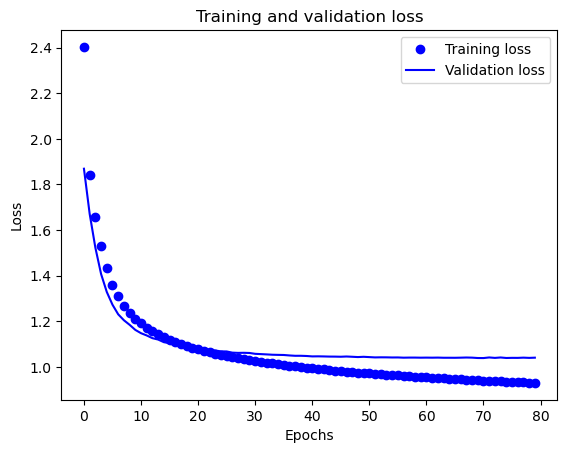

In [71]:
plt.plot(epochs, history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

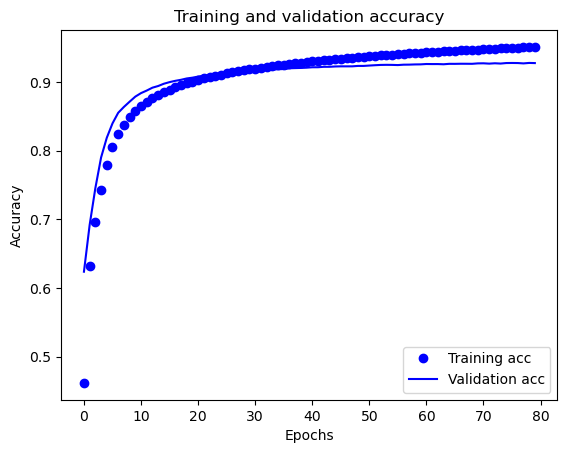

In [72]:
plt.plot(epochs, history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Application

In [73]:
def greedy_decode(model, src_seq, max_len):
    src_embs = model.embedding(src_seq)
    memory = model.transformer.encoder(src_embs)
    tgt_seq = torch.LongTensor([2]).to(DEVICE)  # <s>
    tgt_embs = model.embedding(tgt_seq)
    if max_len > MAX_LEN:
        max_len = MAX_LEN
    for i in range(max_len-1):
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            tgt_embs.size(dim=0))
        tgt_output = model.transformer.decoder(tgt_embs,
                                               memory,
                                               tgt_mask)
        char_prob = model.fc(tgt_output[-1])
        next_char = torch.argmax(char_prob)
        tgt_seq = torch.cat(
            (tgt_seq,
             torch.unsqueeze(next_char, dim=0)), dim=0)
        tgt_embs = model.embedding(tgt_seq)
        if next_char.item() == 3:  # </s>
            break
    return tgt_seq[1:]

In [74]:
def translate(model, src_sentence):
    model.eval()
    src = seqs2tensors([src_sentence], token2idx)[0].to(DEVICE)
    num_chars = src.size(dim=0)
    tgt_chars = greedy_decode(
        model, src, max_len=num_chars + 20)
    tgt_chars = tensors2seqs([tgt_chars], idx2token)[0]
    if tgt_chars[-1] == '</s>':
        tgt_chars = tgt_chars[:-1]
    tgt_str = ''.join(tgt_chars)
    return tgt_str

In [75]:
tgt_sent = translate(translator, "Viens manger")
tgt_sent

'Come eat.'

In [76]:
tgt_sent = translate(translator, "Redkalösköldsfklöte !")
tgt_sent

'Skald Your breath.'

## Save model

In [77]:
# torch.save(translator.state_dict(), MODEL_NAME)
torch.save(translator.state_dict(), MODEL_NAME)

## Evaluate the Model

In [78]:
model = Translator(d_model=D_MODEL,
                   nhead=NHEAD,
                   num_decoder_layers=NUM_ENCODER_LAYERS,
                   num_encoder_layers=NUM_DECODER_LAYERS,
                   dim_feedforward=DIM_FF,
                   vocab_size=VOCAB_SIZE,
                   max_len=MAX_LEN)

In [79]:
model.load_state_dict(torch.load(MODEL_NAME))

<All keys matched successfully>

In [80]:
model.eval()

Translator(
  (embedding): Embedding(
    (input_embedding): Embedding(110, 512, padding_idx=0)
    (pos_embedding): Embedding(102, 512)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwis

In [81]:
model.state_dict()

OrderedDict([('embedding.input_embedding.weight',
              tensor([[-0.0099, -0.0030,  0.0017,  ..., -0.0202, -0.0237, -0.0143],
                      [-0.0100, -0.0032,  0.0016,  ..., -0.0204, -0.0238, -0.0147],
                      [-0.0185, -0.0345,  0.0132,  ..., -0.0586, -0.0439, -0.0431],
                      ...,
                      [ 0.0003,  0.0060,  0.0042,  ..., -0.0224, -0.0257, -0.0083],
                      [ 0.0019, -0.0067,  0.0060,  ..., -0.0083, -0.0253,  0.0145],
                      [-0.0079,  0.0013,  0.0037,  ..., -0.0174, -0.0213, -0.0057]])),
             ('embedding.pos_embedding.weight',
              tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
                        0.0000e+00,  1.0000e+00],
                      [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
                        1.0366e-04,  1.0000e+00],
                      [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
                        2

In [82]:
model = model.to(DEVICE)

In [83]:
translate(model, "Viens manger")

'Come eat.'

In [84]:
cand = []
for i, seq in tqdm(enumerate(val_src_seqs)):
    cand.append(translate(model, seq.strip()))
# cand

20000it [2:18:51,  2.40it/s]


In [85]:
bleu_score(cand, val_tgt_seqs)

tensor(0.5079)